In [1]:
from lib.get_abstracts import get_abstracts
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# get_abstracts('precision medicine', 100, 'ragorham1@gmail.com', '3ffbbb6bd110815d69e4aa14b7c26d72ab09')
# get_abstracts('autoimmune disease', 100, 'ragorham1@gmail.com', '3ffbbb6bd110815d69e4aa14b7c26d72ab09')

In [3]:
df_pre = pd.read_csv('./data/precision medicine.csv', header=-1, dtype={1:str})
df_aut = pd.read_csv('./data/autoimmune disease.csv', header=-1, dtype={1:str})

In [4]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

corpus_pre = []
corpus_aut = []

for i in df_pre.iloc[:,1]:
    corpus_pre.append(i)
corpus_pre = ' '.join(map(str, corpus_pre))
corpus_pre = text_cleaner(corpus_pre)

for i in df_aut.iloc[:,1]:
    corpus_aut.append(i)
corpus_aut = ' '.join(map(str, corpus_aut))
corpus_aut = text_cleaner(corpus_aut)

In [5]:
nlp = spacy.load('en')
corpus_pre_doc = nlp(corpus_pre)
corpus_aut_doc = nlp(corpus_aut)

In [6]:
pre_sent = [[sent, 'precision'] for sent in corpus_pre_doc.sents]
aut_sent = [[sent, 'autoimmune'] for sent in corpus_aut_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(pre_sent + aut_sent)
sentences.shape

(1341, 2)

## Bag of words

In [7]:
def bag_of_words(text):
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(2000)]
    
def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        for word in words:
            df.loc[i, word] += 1
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
precision_words = bag_of_words(corpus_pre_doc)
autoimmune_words = bag_of_words(corpus_aut_doc)

# Combine bags to create a set of unique words.
common_words = set(precision_words + autoimmune_words)

In [8]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000


,orificial,limit,screen,utilize,comorbid,sick,distribution,friendly,antibody,multitest,...,plasma,infarction,young,virtually,respiratory,date,clinical,allergy,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, purpose, of, this, study, was, to, inves...",precision
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Smilacis, Glabrae, Rhizoma, (, SGR, ), ,, kno...",precision
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(The, post, -, harvest, drying, of, SGR, has, ...",precision
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Recent, reports, show, that, sulfur, fumigati...",precision
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Radiology, reports, are, rich, resources, for...",precision


In [9]:
rfc = ensemble.RandomForestClassifier()
y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9875621890547264

Test set score: 0.7560521415270018


In [10]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(804, 3206) (804,)
Training set score: 0.9900497512437811

Test set score: 0.8100558659217877


In [11]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.904228855721393

Test set score: 0.7188081936685289


## tf-idf

In [12]:
df_pre = df_pre.dropna()

abs_pre = []

for abstract in df_pre.iloc[:,1]:
    abs_pre.append(abstract)


In [13]:
X_train, X_test = train_test_split(abs_pre, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
abs_pre_tfidf=vectorizer.fit_transform(abs_pre)
print("Number of features: %d" % abs_pre_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(abs_pre_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1093
Original sentence: RNA-binding proteins (RBPs) play pivotal roles in directing RNA fate and function. Yet the current annotation of RBPs is largely limited to proteins carrying known RNA-binding domains. To systematically reveal dynamic RNA-protein interactions, we surveyed the human proteome by a protein array-based approach and identified 671 proteins with RNA-binding activity. Among these proteins, 525 lack annotated RNA-binding domains and are enriched in transcriptional and epigenetic regulators, metabolic enzymes, and small GTPases. Using an improved CLIP (crosslinking and immunoprecipitation) method, we performed genome-wide target profiling of isocitrate dehydrogenase 1 (IDH1), a novel RBP. IDH1 binds to thousands of RNA transcripts with enriched functions in transcription and chromatin regulation, cell cycle and RNA processing. Purified IDH1, but not an oncogenic mutant, binds directly to GA- or AU-rich RNA that are also enriched in IDH1 CLIP targets. 

In [14]:
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)


abs_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(abs_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 99.99999999999997
Component 0:
Germline variants of <i>PIP4K2A</i> impact susceptibility of acute lymphoblastic leukemia (ALL) through inducing its overexpression. Although limited reports suggested the oncogenic role of <i>PIP4K2A</i> in cancers, regulatory network and prognostic effect of this gene remains poorly understood in tumorigenesis and leukemogenesis. In this study, we conducted genome-wide gene expression association analyses in pediatric B-ALL cohorts to discover expression associated genes and pathways, which is followed by the bioinformatics analyses to investigate the prognostic role of <i>PIP4K2A</i> and its related genes in multiple cancer types. 214 candidates were identified to be significantly associated with <i>PIP4K2A</i> expression in ALL patients, with known cancer-related genes rankings the top (e.g., <i>RAC2</i>, <i>RBL2</i>, and <i>TFDP1</i>). These candidates do not only tend to be clustered in the same types of 

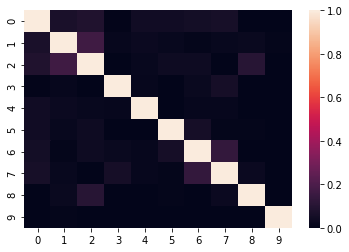

Key:
0 Multiple Myeloma (MM) is an incurable disease characterized by a clonal evolution across the course of the diseases and multiple lines of treatment. Among genomic drivers of the disease, alterations of the tumor suppressor <i>TP53</i> are associated with poor outcomes. In physiological situation, once activated by oncogenic stress or DNA damage, p53 induces either cell-cycle arrest or apoptosis depending on the cellular context. Its inactivation participates to drug resistance in MM. The frequency of <i>TP53</i> alterations increases along with the progression of the disease, from 5 at diagnosis to 75% at late relapses. Multiple mechanisms of regulation lead to decreased expression of p53, such as deletion 17p, <i>TP53</i> mutations, specific microRNAs overexpression, <i>TP53</i> promoter methylations, and <i>MDM2</i> overexpression. Several therapeutic approaches aim to target the p53 pathway, either by blocking its interaction with MDM2 or by restoring the function of the alte

In [15]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])